In [59]:
%matplotlib notebook
import pandas as pd
import numpy as np

import csv
import os
import sys

from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.externals import joblib
from sklearn.metrics import log_loss
import xgboost as xgb

import matplotlib.pyplot as plt

In [73]:

# XGBoost params:
xgboost_params = { 
   "objective": "binary:logistic",
   "booster": "gbtree",
   "eval_metric": ["auc","error","map","logloss"],
   "eta": 0.01, # 0.06, #0.01,
   #"min_child_weight": 240,
   "subsample": 0.75,
   "colsample_bytree": 0.68,
   "max_depth": 7
}

print('Load data...')
train = pd.read_csv('data/train.csv')
target = train['target']
train = train.drop(['ID','target'],axis=1)
test = pd.read_csv('data/test.csv')
ids = test['ID'].values
test = test.drop(['ID'],axis=1)
#




Load data...


In [14]:
# Define a function, dummify, that will replace categorical features with dummy columns. Return the new dataset,
# the names of the dummy columns, and the rows with null values for each categorical variable
def dummify(name,series):
    prefix_string = name + '_'
    dummies = pd.get_dummies(series,prefix=prefix_string)
    dummy_column_names = dummies.columns.values
    #Get a list of all rows containing nulls. After dummifying these rows will just have all zeros for dummy variable
    get_nulls = np.where(series.isnull() == True)[0].tolist()

    return dummies, dummy_column_names, get_nulls

In [70]:
print('Clearing...')

train_dummy_columns = {}
train_nulls_dict = {}
test_dummy_columns = {}
test_nulls_dict = {}


cleaned_train = train.copy()
cleaned_test = test.copy()


for (train_name, train_series), (test_name, test_series) in zip(train.iteritems(),test.iteritems()):
    if train_name == 'v22':
        #v22 has too many options to dummify, instead: factorize
        cleaned_train[train_name], tmp_indexer = pd.factorize(train[train_name])
        cleaned_test[test_name] = tmp_indexer.get_indexer(test[test_name])
        #but now we have -1 values (NaN)    
    elif train_series.dtype == 'O':
        print 'Dummifying ' + train_name
        cleaned_train.drop(train_name,axis=1,inplace = True)
        cleaned_test.drop(train_name,axis=1,inplace = True)
        
        train_dummies, train_dummy_list, train_null_list = dummify(train_name,train_series)
        test_dummies, test_dummy_list, test_null_list = dummify(test_name,test_series)

        cleaned_train = pd.concat([cleaned_train,train_dummies], axis = 1)
        cleaned_test = pd.concat([cleaned_test,test_dummies], axis = 1)

        train_dummy_columns[train_name] = train_dummy_list
        train_nulls_dict[train_name] = train_null_list
        test_dummy_columns[test_name] = test_dummy_list
        test_nulls_dict[test_name] = test_null_list
        
    else:
        #for int or float: fill NaN
        tmp_len = len(train[train_series.isnull()])
        if tmp_len>0:
            cleaned_train.loc[train_series.isnull(), train_name] = train_series.mean()
        #and Test
        tmp_len = len(test[test_series.isnull()])
        if tmp_len>0:
            cleaned_test.loc[test_series.isnull(), test_name] = train_series.mean()  #TODO

Clearing...
Dummifying v3
Dummifying v24
Dummifying v30
Dummifying v31
Dummifying v47
Dummifying v52
Dummifying v56
Dummifying v66
Dummifying v71
Dummifying v74
Dummifying v75
Dummifying v79
Dummifying v91
Dummifying v107
Dummifying v110
Dummifying v112
Dummifying v113
Dummifying v125


Fit the model...
Training....


Will train until valid error hasn't decreased in 100 rounds.
Multiple eval metrics have been passed: 'logloss' will be used for early stopping.

[0]	valid-auc:0.737278	valid-error:0.221587	valid-map:0.893612	valid-logloss:0.689359
[50]	valid-auc:0.755536	valid-error:0.220129	valid-map:0.902754	valid-logloss:0.570074
[100]	valid-auc:0.757664	valid-error:0.219371	valid-map:0.904376	valid-logloss:0.515968
[150]	valid-auc:0.759824	valid-error:0.219255	valid-map:0.905594	valid-logloss:0.490015
[200]	valid-auc:0.761067	valid-error:0.219255	valid-map:0.906277	valid-logloss:0.477241
[250]	valid-auc:0.762400	valid-error:0.218613	valid-map:0.907035	valid-logloss:0.470333
[300]	valid-auc:0.763259	valid-error:0.218147	valid-map:0.907500	valid-logloss:0.466606
[350]	valid-auc:0.764113	valid-error:0.218438	valid-map:0.908010	valid-logloss:0.464390
[400]	valid-auc:0.764604	valid-error:0.218089	valid-map:0.908346	valid-logloss:0.463009
[450]	valid-auc:0.765017	valid-error:0.217564	valid-map:0.908615	v

0.769642
0.457057
2148


<IPython.core.display.Javascript object>


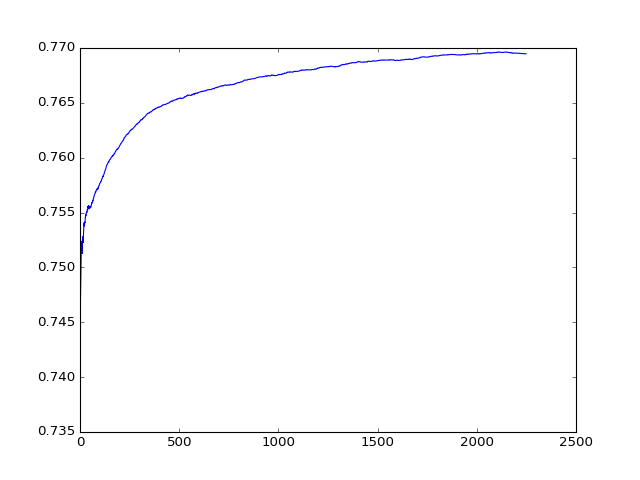

In [75]:
X_train, X_valid, y_train, y_valid = train_test_split(cleaned_train.values, target.values, test_size=0.15, random_state = 1)

final = False

# xgtrain = xgb.DMatrix(train.values, target.values)
# xgtest = xgb.DMatrix(test.values)

xgtrain = xgb.DMatrix(X_train, y_train)
xgvalid = xgb.DMatrix(X_valid, y_valid)
xgtest = xgb.DMatrix(cleaned_test.values)

if final == True:
    xgtrain = xgb.DMatrix(cleaned_train.values, target.values)
    

#Now let's fit the model
print('Fit the model...')
boost_round = 2500 #1800 CHANGE THIS BEFORE START

filename = 'data/model/xgb-dummy-except-v22.pkl'
if not os.path.exists(filename):
    print 'Training....'
    eval_dict = dict()
    if final == False:
        clf = xgb.train(xgboost_params, xgtrain, num_boost_round=boost_round, verbose_eval=50, maximize=False,
                    evals_result=eval_dict, early_stopping_rounds=100, evals=[(xgvalid, 'valid')])
    else:
    # Use the following when not using validation a.k.a. for final run
        clf = xgb.train(xgboost_params,xgtrain,num_boost_round=boost_round,verbose_eval=True,maximize=False)
    joblib.dump(clf, filename)
else:
    print 'Loading...'
    clf = joblib.load(filename)

# ------------------
#print(eval_dict)
if final == False:
    score_list = [float(s) for s in eval_dict['valid']['auc']]
    print(max(score_list))   # There are best score (max() - for 'auc', but min() for logloss)
    #same result:
    print(clf.best_score) 
    #and best xgboost_round:
    print(clf.best_iteration)


    plt.plot(score_list)
    plt.show()


In [36]:

#----------------    
# Code for predicting on test data and saving prediction result
# Make predict
print('Predict...')
filename = 'data/model/xgb-dummy-except-v22_submit.pkl'
clf = joblib.load(filename)
test_preds = clf.predict(xgtest, ntree_limit=clf.best_iteration)
# Save results
#
predictions_file = open("data/team_GAF_result.csv", "w")
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(["ID", "PredictedProb"])
open_file_object.writerows(zip(ids, test_preds))
predictions_file.close()
#
print('Done.')

Predict...
Done.


[]

In [78]:
log_loss(y_valid, valid_preds)

0.45705718341173746

In [77]:
valid_preds = clf.predict(xgb.DMatrix(X_valid), ntree_limit=clf.best_iteration)
# valid_preds[0:10]
# # y_valid[0:10]
# valid_preds[valid_preds >= 0.5] = 1
# valid_preds[valid_preds < 0.5] = 0
# result = np.equal(valid_preds,y_valid)
# number_true = np.sum(result)
# float(number_true) / len(result)

In [62]:
log_loss(y_valid, valid_preds)

0.37158153649657194

0.37158153649657194